# Lebesgue constants

For the third lab assignment, we numerically investigate the Lebesgue constants of various approximations studied in class.

## 1. Chebyshev interpolation
We evaluate $$\lambda_n(x)=\sum_{k=0}^n |\phi_{n,k}(x)|$$ at $x = 1$ for several values of $n$ in order to plot $\lVert L_n\rVert$ against $n$. We confirm that $\lVert L_n\rVert$ grows like $C\log n$ and we find $C$ to be around 0.42.

0.423308967898


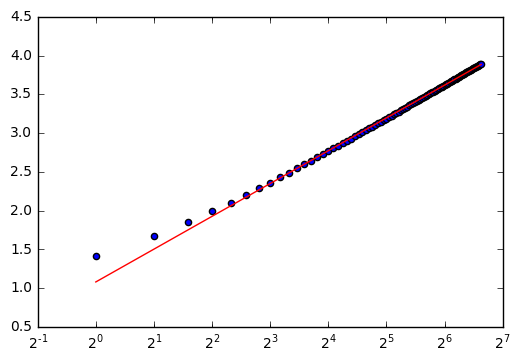

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import functools

def lagrangeCoeffs(n, nodes, x):
    # Finds the value phi_(n,k)(x) for all k = 0...n using the formula for lagrange polynomials
    return [np.prod([(x-nodes[i])/(nodes[k]-nodes[i]) for i in range(n+1) if i!= k]) for k in range(n+1)]

x = range(1,100)
y = []
for n in x:
    # Defines chebyshev nodes for n and finds sums the absolute value of the lagrange coeffs
    chebNodes = [np.cos((2*k-1)*np.pi/(2*(n+1))) for k in range(1,n+2)]
    y.append(sum(map(np.abs, lagrangeCoeffs(n, chebNodes, 1))))

#Plotting and fitting the plot
plt.scatter(x,y)
fits = np.polyfit(np.log2(x[4:]), y[4:], 1)
print(fits[0])
y = [fits[0]*np.log2(x[i]) + fits[1] for i in range(len(x))]
plt.plot(x,y, 'red')
plt.xscale('log', basex=2)
plt.show()

## 2. Equidistant interpolation

In order to find the global maximum, we use the NewtonRaphson method on $\lambda_n'$ on $(x_0, x_1)$. To compute $\lambda_n'$, we first derive an expression for $\phi'_{n,k}$:
$$ \phi'_{n,k} = \sum_{\substack{i=0\\i\neq k}}^n \left( \frac{(x-x_0) \cdots \widehat{(x-x_i)} \cdots \widehat{(x-x_k)}\cdots (x-x_n)}{(x_k-x_0)\cdots \widehat{(x_k-x_k)}\cdots (x_k-x_n)} \right).$$
Then, we can compute $\lambda_n'$:
$$ \lambda_n'(x) = \sum_{k=0}^n \text{sgn}(\phi_{n,k}(x))\cdot \phi'_{n,k}(x).$$

To find the roots of this function, we use the secant method so that we do not have to compute the second derivative of $\lambda_n$. We use the following iteration formula:
$$ x_n = x_{n-1} - f(x_{n-1})\frac{x_{n-1} - x_{n-2}}{f(x_{n-1}) - f(x_{n-2})}$$

We confirm that $\lVert L_n \rVert \approx 2^n$ because with the log scale on the $y$ axis, we get a straght line.

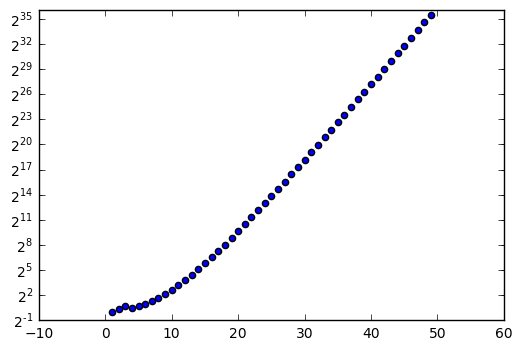

In [264]:
def lagrangePrimeCoeffs(n, nodes, x):
    # Finds the value phi'_(n,k)(x) for all k = 0...n using the formula above
    return [sum([np.prod([(x-nodes[j])/(nodes[k]-nodes[j]) for j in range(n+1) if j!= i and j!=k])*1/(nodes[k]-nodes[i]) for i in range(n+1) if i!=k]) for k in range(n+1)]

def lambPrime(n, nodes, x):
    # Returns the value of lambda_n'(x)
    return sum([x*y for (x,y) in zip(lagrangePrimeCoeffs(n, nodes, x), map(np.sign, lagrangeCoeffs(n, nodes, x)))])

def secantMethod(f, start, eps):
    # iterates with the secant method rule change is smaller than epsilon 
    pprev, prev = start
    while np.abs(prev- pprev) > eps:
        fp, fpp = f(prev), f(pprev)
        pprev, prev = prev, prev - fp*(prev - pprev)/(fp-fpp)
    return prev

def getMaxLambd(n):
    # returns the max of lambda_n inside (x_0,x_1) by finding the root of lambda'_n and evaluating
    nodes = np.linspace(0,1, n+1)
    f = functools.partial(lambPrime, n, nodes)
    x = (secantMethod(f, (0,1/(n+1)), 0.0001))
    return sum(map(np.abs, lagrangeCoeffs(n, nodes, x)))

x = range(1,50)
y = list(map(getMaxLambd, x))
plt.scatter(x,y)
plt.yscale('log', basey=2)
plt.show()

## 3 - Chebyshev truncation
We compute the Lebesgue constant for Chebyshev truncation. We confirm that $\lVert S_n \rVert \approx C\log n$, with $C \approx 0.43$.

0.432379905031


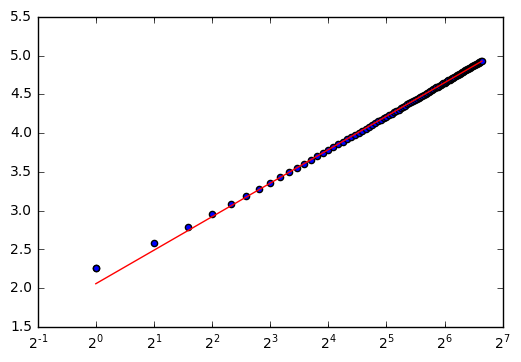

In [268]:
def simpsonComposite(f, points):
    # uses Simpson's rule to approximate the integral
    # of f inside the intervals defined by points and
    # returns the sum of all integrals
    sum = 0
    for i in range(len(points)-1): # for each interval
        a, b = points[i:i+2]
        sum += (b-a)/6 *(f(a) + 4*f((a+b)/2) + f(b)) # Simpson's rule
    return sum

def getLebConstChebTrunc(n):
    # computes the lebesque constant for chebyshev truncation
    def f(x):
        # this function is the integrand for ||S_n||
        if x == 0:
            return 2*n+1 # Value when x = 0 because otherwise it is undefined (defined by the limit)
        return np.abs((np.sin((n+1/2)*x))/(2*np.sin(x/2)))
    
    # the points are the roots of the integrand to get better approximations in each interval
    return simpsonComposite(f, np.linspace(0,np.pi,10000))
    #return simpsonComposite(f, [k*(np.pi)/(k+1/2) for k in range(n+1)] + [np.pi])

x = list(map(int,np.linspace(1,100,101)))
y = list(map(getLebConstChebTrunc, x))
plt.xscale('log', basex=2)
plt.scatter(x,y)
fits = np.polyfit(np.log2(x[4:]), y[4:], 1)
print(fits[0])
y = [fits[0]*np.log2(x[i]) + fits[1] for i in range(len(x))]
plt.plot(x,y, 'red')
plt.show()

## 4 - Legendre truncation
We confirm that $\lVert S_n \rVert \approx C\sqrt{n}$ with $C \approx 1.52$.

1.52536162266


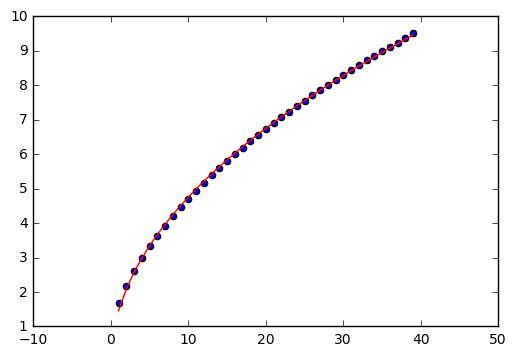

In [271]:
def legRecRule(t,s, n):
    # Applies the recurrence rule that defines Legendre polynomials with t and s at step n
    # Namely: return (2n-1)/n*x*t-(n-1)*s (Bonnet recurence)
    t = [0]+[(2*n-1)/n*x for x in t] # mult t by (2n-1)/n*x
    s = [(1-n)/n*x for x in s] + [0,0] # mult t by 1-n and pad with zeros to be able to add
    return [sum(x) for x in zip(t,s)] # add t and s
    
def getLegPolys(n):
    # Returns Legendre polynomials P_0, ..., P_n
    leg = (n+1)*[[]]
    leg[0] = [1] #P_0(x) = 1
    leg[1] = [0,1] #P_1(x) = x
    for i in range(2,n+1):
        leg[i] = legRecRule(leg[i-1], leg[i-2], i)
    return leg

def integrand(n, polys, x):
    # integrand for legendre truncation
    return np.abs(sum([(k+1/2)*evalPoly(polys[k],x) for k in range(n+1)]))

x = range(1,40)
poly = getLegPolys(40)
y = [simpsonComposite(functools.partial(integrand, n, poly), np.linspace(-1,1,1000)) for n in x]
plt.scatter(x,y)
fits = np.polyfit(np.sqrt(x), y, 1)
print(fits[0])
y = [fits[0]*np.sqrt(x[i]) + fits[1] for i in range(len(x))]
plt.plot(x,y, 'red')
plt.show()

## 5 - Newton-Cotes
This does not work for some reason.

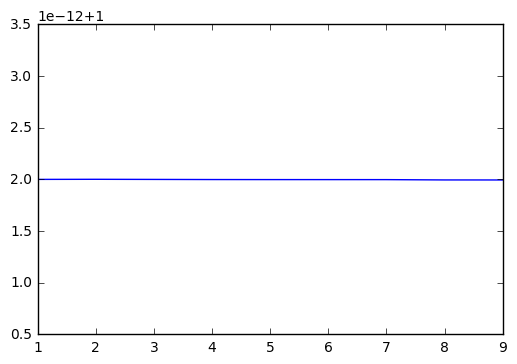

In [277]:
def phi(n, k, nodes, x):
    return np.prod([(x-nodes[i])/(nodes[k]-nodes[i]) for i in range(n+1) if i!= k])

def newCotes(n):
    return sum(np.abs([simpsonComposite(functools.partial(phi,n,k,np.linspace(0,1,n+1)), np.linspace(0, 1, 10000)) for k in range(n+1)]))

x = range(1,50)
y = list(map(newCotes, x))

plt.plot(x,y)
plt.show()